# Hypothesis testing validation

Power analysis for DM, DV, and DC

In [1267]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy.api as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time
import string

In [10]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [11]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/scmemo')
import estimator, simulate, scmemo, bootstrap, util, hypothesis_test

In [12]:
import sys
sys.path.append('/home/ssm-user/Github/single_cell_eb/')
sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb')
import scdd

### Simulate some data

In [1289]:
true_data = simulate.simulate_transcriptomes(10000, 2000, correlated=False)
qs, captured_data = simulate.capture_sampling(true_data, q=0.1, q_sq=0.011)


### Perform real bootstrap

Perform bootstrap for two different sets of genes to test for generalizablilty of the bootstrap approximation.

adata_1 is for fitting, adata_2 is for testing

In [1290]:
imp.reload(estimator)
imp.reload(bootstrap)
imp.reload(scmemo)
imp.reload(util)

adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
adata.obs['ct'] = np.random.choice(2, adata.shape[0])
# adata.obs['ind'] = np.random.choice(list('aef'), adata.shape[0])

adata_scmemo = adata.copy()
adata_scmemo.X = adata_scmemo.X.astype(np.int64)
scmemo.create_groups(adata_scmemo, label_columns=['ct'], inplace=True)

scmemo.compute_1d_moments(adata_scmemo, inplace=True, filter_genes=True, residual_var=True, use_n_umi=False, filter_mean_thresh=0.2, min_perc_group=.9)

In [1328]:
adata_scmemo.shape

(10000, 1093)

In [ ]:
all_cell_means = adata_scmemo.X.mean(axis=0).A1


In [1343]:
gamma_1, gamma_2, gamma_3 = 0.1, 1.3, 2.1
expr_1, expr_2, expr_3 = 1, 2, 3

In [1344]:
print(expr_1/gamma_1+expr_2/gamma_2+expr_3/gamma_3)

12.967032967032967


In [1345]:
inv_mean = np.mean([1/gamma_1, 1/gamma_2, 1/gamma_3])

In [1346]:
(expr_1+expr_2+expr_3)*inv_mean

22.490842490842493

In [1324]:
num_gene_bins = 100
gene_selection_df = pd.DataFrame()
gene_selection_df['mean_expression'] = adata_scmemo.X.mean(axis=0).A1
bin_edges = np.quantile(gene_selection_df['mean_expression'], np.linspace(0, 0.99, num_gene_bins))
# _, bin_edges = np.histogram(gene_selection_df['mean_expression'], bins=num_gene_bins)
gene_selection_df['expression_bin'] = np.digitize(gene_selection_df['mean_expression'], np.unique(bin_edges))
bin_counts = gene_selection_df.groupby('expression_bin').agg({'mean_expression':['mean', 'count']})
sample_genes = gene_selection_df.groupby('expression_bin').apply(lambda x: pd.DataFrame.sample(x, 5))
# gene_selection_df.groupby('expression_bin').apply(lambda x: pd.DataFrame.sample(x, 10))

In [1270]:
expression_bins

[a, a, a, a, a, ..., a, a, a, a, a]
Length: 2853
Categories (20, object): [a < b < c < d ... q < r < s < t]

In [1266]:
mean_expression

array([0.3367, 0.9521, 0.7789, ..., 0.5821, 1.1345, 2.7891])

In [1196]:
%%time
num_boot=1000
### Perform real bootstrap
adata_1 = adata_scmemo[adata_scmemo.obs['ct'] == 0][:, :500]
adata_2 = adata_scmemo[adata_scmemo.obs['ct'] == 1][:, 500:1000]
sf_1 = adata_scmemo.uns['scmemo']['size_factor']['sg^0']
sf_2 = adata_scmemo.uns['scmemo']['size_factor']['sg^1']

# mean_diff = np.zeros((num_boot, adata_1.shape[1]))
# var_diff = np.zeros((num_boot, adata_1.shape[1]))
mean_1 = np.zeros((num_boot, adata_1.shape[1]))
mean_2 = np.zeros((num_boot, adata_1.shape[1]))
var_1 = np.zeros((num_boot, adata_1.shape[1]))
var_2 = np.zeros((num_boot, adata_1.shape[1]))

for boot in range(num_boot):
    
    if boot % 200 == 0:
        print(boot)
    boot_idx_1 = np.random.choice(adata_1.shape[0], adata_1.shape[0])
    boot_idx_2 = np.random.choice(adata_2.shape[0], adata_2.shape[0])
    
    mean_1[boot, :], var_1[boot, :] = estimator._poisson_1d(adata_1.X[boot_idx_1], adata_1.shape[0], size_factor=sf_1[boot_idx_1], n_umi=adata_scmemo.uns['scmemo']['n_umi'])
    mean_2[boot, :], var_2[boot, :] = estimator._poisson_1d(adata_2.X[boot_idx_2], adata_2.shape[0], size_factor=sf_2[boot_idx_2], n_umi=adata_scmemo.uns['scmemo']['n_umi'])
    
#     mean_diff[boot, :] = mean_2[boot, :] - mean_1[boot, :]
#     var_diff[boot, :] = var_2[boot, :] - var_1[boot, :]

0
200
400
600
800
CPU times: user 1min 42s, sys: 373 ms, total: 1min 42s
Wall time: 1min 42s


In [1197]:
# mean_pval = 2*(np.minimum((mean_diff > 0).sum(axis=0), 5000- (mean_diff > 0).sum(axis=0))+1)/(5000+1)
# var_pval = 2*(np.minimum((var_diff > 0).sum(axis=0), 5000- (var_diff > 0).sum(axis=0))+1)/(5000+1)

### Approximate bootstrap for the first 500 genes and fit the curve for bootstrap variance

In [1198]:
mat_1 = adata_1.X.tocsc()
mat_2 = adata_2.X.tocsc()

In [1244]:
%%time
# for gene_idx in range(20):
num_gene_to_test = 500
imp.reload(bootstrap)
num_bins = 1
# var_var_diff = np.zeros(num_gene_to_test)
# var_mean_diff = np.zeros(num_gene_to_test)
# unique_count = np.zeros(num_gene_to_test)
var_var_1 = np.zeros(num_gene_to_test)
var_mean_1 = np.zeros(num_gene_to_test)
unique_count_1 = np.zeros(num_gene_to_test)

for gene_idx in range(num_gene_to_test):
    
    if gene_idx % 100 == 0:
        print(gene_idx)
    mean_1_approx, var_1_approx, s1= bootstrap._bootstrap_1d(
        mat_1[:, gene_idx],
        sf_df=bootstrap._create_size_factor_df(sf_1), 
        n_umi=adata_scmemo.uns['scmemo']['n_umi'],
        num_boot=10000,
        bins=num_bins,
        dirichlet_approx=True,
        log=False)
    
    var_var_1[gene_idx] = var_1_approx.var()
    var_mean_1[gene_idx] = mean_1_approx.var()
    unique_count_1[gene_idx] = s1

#     mean_2_approx, var_2_approx, s2= bootstrap._bootstrap_1d(
#         mat_2[:, gene_idx], 
#         sf_df=bootstrap._create_size_factor_df(sf_2), 
#         n_umi=adata_scmemo.uns['scmemo']['n_umi'],
#         num_boot=10000,
#         bins=num_bins,
#         dirichlet_approx=True,
#         log=False)
    
#     real_var_diff = var_2[:, gene_idx]-var_1[:, gene_idx]
#     approx_var_diff = var_2_approx-var_1_approx
    
#     real_mean_diff = mean_2[:, gene_idx]-mean_1[:, gene_idx]
#     approx_mean_diff = mean_2_approx-mean_1_approx
    
#     var_mean_diff[gene_idx] = real_mean_diff.var()-approx_mean_diff.var()
#     var_var_diff[gene_idx]=real_var_diff.var()-approx_var_diff.var()
#     unique_count[gene_idx]=(s1+s2)/2

0
100
200
300
400
CPU times: user 6.35 s, sys: 0 ns, total: 6.35 s
Wall time: 6.35 s


In [1259]:
from scipy.optimize import least_squares

def transform(poly_fit, unique_count):
    
#     return poly_fit[0]*unique_count**2 + poly_fit[1]*unique_count
    return np.poly1d(poly_fit)(unique_count)
#     return poly_fit[0]*10**(poly_fit[1]*unique_count)

def loss(poly_fit, unique_count, var_diff):
    return var_diff - transform(poly_fit, unique_count)

#     return var_diff - np.poly1d(poly_fit)(unique_count)

mean_fit = least_squares(loss, np.zeros(4), args=(unique_count_1, mean_1.var(axis=0) - var_mean_1), loss='huber').x
var_fit = least_squares(loss, np.zeros(4), args=(unique_count_1, var_1.var(axis=0) - var_var_1), loss='huber').x
var_poly = np.poly1d(var_fit)
mean_poly = np.poly1d(mean_fit)
print(mean_fit, var_fit)

[-3.57351547e-09  1.48361477e-06 -1.38769183e-05 -6.56126048e-07] [ 1.20101802e-06  1.37367904e-04 -3.63012806e-03  1.85529068e-02]


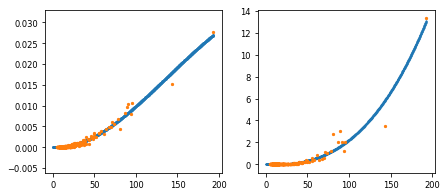

In [1260]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
unique_counts_range = np.linspace(0, unique_count_1.max(), 1000)
plt.scatter(unique_counts_range, transform(mean_fit, unique_counts_range), s=2)
plt.scatter(unique_count_1, mean_1.var(axis=0) - var_mean_1, s=5)

# plt.xlim(0, 100);
# plt.ylim(-.01, 0.025)


plt.subplot(1, 2, 2)
# plt.scatter(unique_counts_range, var_poly(unique_counts_range), s=1)
plt.scatter(unique_counts_range, transform(var_fit, unique_counts_range), s=1)
plt.scatter(unique_count_1, var_1.var(axis=0) - var_var_1, s=5)
# plt.xlim(0, 100)
# plt.ylim(-1, 10)

### Approximate bootstrap for the second set of 500 genes and inject noise

In [1261]:
%%time
# for gene_idx in range(20):
num_gene_to_test = 500
imp.reload(bootstrap)
num_bins = 1
var_var_2 = np.zeros(num_gene_to_test)
var_mean_2 = np.zeros(num_gene_to_test)
unique_count_2 = np.zeros(num_gene_to_test)

for gene_idx in range(num_gene_to_test):
    
    if gene_idx % 100 == 0:
        print(gene_idx)
    mean_2_approx, var_2_approx, s2= bootstrap._bootstrap_1d(
        mat_2[:, gene_idx],
        sf_df=bootstrap._create_size_factor_df(sf_2), 
        n_umi=adata_scmemo.uns['scmemo']['n_umi'],
        num_boot=10000,
        bins=num_bins,
        dirichlet_approx=True,
        log=False)
    mean_noise = transform(mean_fit, s2)
    var_noise = transform(var_fit, s2)
    
    if mean_noise > 0:
        mean_2_approx[1:] += stats.norm.rvs(loc=0, scale=np.sqrt(mean_noise), size=10000)
    if var_noise > 0:
        var_2_approx[1:] += stats.norm.rvs(loc=0, scale=np.sqrt(var_noise), size=10000)

    var_var_2[gene_idx] = var_2_approx.var()
    var_mean_2[gene_idx] = mean_2_approx.var()
    unique_count_2[gene_idx] = s2

0
100
200
300
400
CPU times: user 7.31 s, sys: 12.3 ms, total: 7.32 s
Wall time: 7.31 s


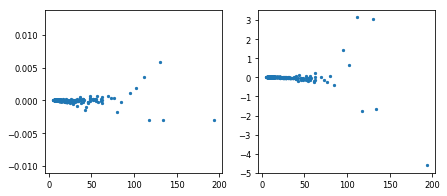

In [1329]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.scatter(unique_count_2, mean_2.var(axis=0) - var_mean_2, s=5)


plt.subplot(1, 2, 2)
plt.scatter(unique_count_2, var_2.var(axis=0) - var_var_2, s=5)
# plt.xlim(0, 70);


In [1356]:
np.argsort(adata_1.X.mean(axis=0).A1)[::-1][:10]

array([224, 481, 275, 340, 312,  47, 416, 346, 379, 236])

### Small example

In [2190]:
def _precompute_size_factor(expr, sf_df, bins):
	"""
		Precompute the size factor to separate it from the bootstrap.
		This function also serves to find and count unique values.
		
		:sf_df: is already a dictionary with memory already allocated to speed up the calculations.
		It should already include the inverse of size factors and inverse of the squared size factors.
	"""
	
	# Get the expression values into the DataFrame
	if expr.ndim > 1:
		sf_df['expr'] = np.random.random()*expr[:, 0]+np.random.random()*expr[:, 1]
		sf_df['expr1'], sf_df['expr2'] = expr[:, 0], expr[:, 1]
	else:
		sf_df['expr'] = expr
	
	# Create bins for size factors
	if bins == 1:
		sf_df['bin'] = 1
	elif bins == 2:
		sf_df['bin_cutoff'] = sf_df.groupby('expr', sort=True)['size_factor'].transform('mean')
		sf_df['bin'] = sf_df['size_factor'] > sf_df['bin_cutoff']
	else:
		sf_df['bin'] = sf_df.groupby('expr', sort=True)['size_factor'].transform(lambda x: _create_bins(x, bins))
	
	groupby_obj = sf_df.groupby(['expr', 'bin'], sort=True)
	precomputed_sf = groupby_obj[['inv_size_factor', 'inv_size_factor_sq']].mean().dropna()
	
	# Get unique expression values
	if expr.ndim > 1:
		unique_expr = groupby_obj[['expr1', 'expr2']].first().dropna().values
	else:
		unique_expr = precomputed_sf.index.get_level_values(0).values.reshape(-1, 1)
	
	# Get unique counts
	counts = groupby_obj.size().values
					
	return (
		precomputed_sf['inv_size_factor'].values.reshape(-1, 1), 
		precomputed_sf['inv_size_factor_sq'].values.reshape(-1, 1),
		unique_expr,
		counts)

def _create_bins(x, num_bins):
	""" Small helper function to create bins dynamically. """
	
# 	bin_edges = np.quantile(x, np.linspace(0, 1, num_bins))

	if x.shape[0] < 20:
		return 1
	_, bin_edges = np.histogram(x, bins=num_bins)
	
	return np.digitize(x, np.unique(bin_edges))

	return pd.cut(x, bins=num_bins, labels=list(string.ascii_lowercase)[:num_bins])

In [2290]:
data = adata_1.X[:, 6].todense().A1
data = adata_1.X[:, 0].todense().A1

all_sf = sf_1
normalized_data = (data/all_sf)

# Algorithm for figuring out number of bins
unique_counts = np.unique(data).shape[0]
num_bins = min(unique_counts, 8)
print(num_bins)

_, sf_bin_edges = np.histogram(data_sf, bins=num_bins)
# sf_bin_edges = np.quantile(all_sf, np.linspace(0, 1,10))
binned_stat = stats.binned_statistic(all_sf, all_sf, bins=sf_bin_edges, statistic='median')
approx_sf = binned_stat[0][binned_stat[2]-1]

binned_normalized_data = (data/approx_sf)

8


In [2291]:
unique_counts

8

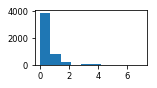

In [2292]:
plt.figure(figsize=(2,1))
plt.hist(data);

In [2293]:
%%time
real_boot_mean_dist = np.array([normalized_data[np.random.choice(data.shape[0], data.shape[0])].mean() for i in range(10000)])
real_boot_var_dist = np.array([normalized_data[np.random.choice(data.shape[0], data.shape[0])].var() for i in range(10000)])

real_binned_boot_mean_dist = np.array([binned_normalized_data[np.random.choice(data.shape[0], data.shape[0])].mean() for i in range(10000)])
real_binned_boot_var_dist = np.array([binned_normalized_data[np.random.choice(data.shape[0], data.shape[0])].var() for i in range(10000)])

CPU times: user 4.03 s, sys: 3.96 ms, total: 4.04 s
Wall time: 4.03 s


In [2294]:
%%time
# Approximation #1
sf_df = pd.DataFrame()
sf_df['expr'] = data
sf_df['size_factor'] = all_sf
sf_df['inv_size_factor'] = 1/data_df['sf']
sf_df['inv_size_factor_sq'] = 1/data_df['sf']**2
sf_df['bin'] = 1

inv_sf, inv_sf_sq, expr, counts = _precompute_size_factor(
    expr=data, 
    sf_df=sf_df,
    bins=unique_counts)
# precomputed_sf = data_df.groupby('expr')['inv_sf', 'inv_sf_sq'].mean()
# expr, count = np.unique(data, return_counts=True)


mult_rvs = stats.multinomial.rvs(n=data.shape[0], p=counts/data.shape[0], size=10000).T

approx_boot_mean_dist = (expr.reshape(-1, 1) * mult_rvs * inv_sf).sum(axis=0)/data.shape[0]
approx_boot_var_dist = (expr.reshape(-1, 1)**2 * mult_rvs * inv_sf_sq).sum(axis=0)/data.shape[0] - approx_boot_mean_dist**2

CPU times: user 71.6 ms, sys: 145 µs, total: 71.8 ms
Wall time: 70.9 ms


In [2295]:
%%time
# Approximation #2
expr_sf_data = np.vstack([data, approx_sf]).T
expr_sf, index, count = np.unique(expr_sf_data, return_index=True, return_counts=True, axis=0)
expr, sf = expr_sf[:, 0], expr_sf[:, 1]
inv_sf = 1/sf.reshape(-1, 1)#inv_approx_sf[index].reshape(-1, 1)
inv_sf_sq = 1/sf.reshape(-1, 1)**2#inv_approx_sf_sq[index].reshape(-1, 1)

mult_rvs = stats.multinomial.rvs(n=data.shape[0], p=count/data.shape[0], size=10000).T
approx_boot_mean_dist = (expr.reshape(-1, 1) * mult_rvs * inv_sf).sum(axis=0)/data.shape[0]
approx_boot_var_dist = (expr.reshape(-1, 1)**2 * mult_rvs * inv_sf_sq).sum(axis=0)/data.shape[0] - approx_boot_mean_dist**2

CPU times: user 55.7 ms, sys: 158 µs, total: 55.8 ms
Wall time: 55.1 ms


In [2296]:
print('width of real boot mean', real_boot_mean_dist.var())
print('width of real binned boot mean', real_binned_boot_mean_dist.var())
print('width of approximated boot mean', approx_boot_mean_dist.var())

print('width of real boot var', real_boot_var_dist.var())
print('width of real binned boot var', real_binned_boot_var_dist.var())
print('width of approximated boot var', approx_boot_var_dist.var())

width of real boot mean 0.00011141679125869778
width of real binned boot mean 0.00011277844545542452
width of approximated boot mean 0.00011126889651362551
width of real boot var 0.0008789314152870943
width of real binned boot var 0.0008595446807466704
width of approximated boot var 0.0008782631035107832


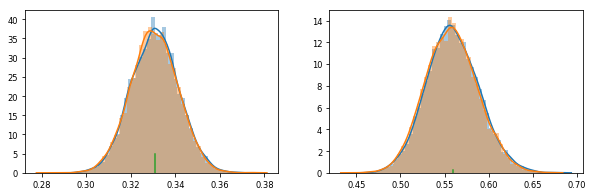

In [2297]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
sns.distplot(real_boot_mean_dist)
# sns.distplot(real_binned_boot_mean_dist)
sns.distplot(approx_boot_mean_dist)
plt.plot([normalized_data.mean(), normalized_data.mean()], [0, 5])

plt.subplot(1, 2, 2)
sns.distplot(real_boot_var_dist)
# sns.distplot(real_binned_boot_var_dist)
sns.distplot(approx_boot_var_dist)

plt.plot([normalized_data.var(), normalized_data.var()], [0, 0.25])


In [1089]:
var_fit

array([ 0.00087632, -0.03543521,  0.29207934])

In [1090]:
from scipy.optimize import least_squares
def loss(poly_fit, unique_count, var_diff):
    
    return var_diff - np.poly1d(poly_fit)(unique_count)

mean_fit = least_squares(loss, np.ones(3), args=(unique_count, var_mean_diff), loss='soft_l1').x
var_fit = least_squares(loss, np.ones(3), args=(unique_count, var_var_diff), loss='soft_l1').x
print(mean_fit, var_fit)

In [1091]:
from scipy.optimize import least_squares

In [1092]:
mean_fit = least_squares(loss, np.ones(3), args=(unique_count, var_mean_diff), loss='soft_l1').x
var_fit = least_squares(loss, np.ones(3), args=(unique_count, var_var_diff), loss='soft_l1').x
print(mean_fit, var_fit)

[ 1.46767379e-06  4.41900691e-05 -6.59208097e-04] [ 0.00093671 -0.03944035  0.33236043]


In [1093]:
mean_fit = np.polyfit(unique_count, var_mean_diff, 2)
var_fit = np.polyfit(unique_count, var_var_diff, 2)
print(mean_fit, var_fit)

[ 1.46767333e-06  4.41901222e-05 -6.59208734e-04] [ 0.00090788 -0.03976201  0.34657496]


In [1094]:
var_poly = np.poly1d(var_fit)
mean_poly = np.poly1d(mean_fit)

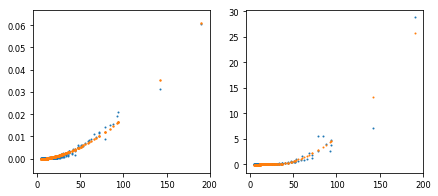

In [1095]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.scatter(unique_count, var_mean_diff, s=1)
plt.scatter(unique_count, mean_poly(unique_count), s=2)

# plt.xlim(0, 100);
# plt.ylim(-.01, 0.025)


plt.subplot(1, 2, 2)
plt.scatter(unique_count, var_var_diff, s=1)
plt.scatter(np.sort(unique_count), np.sort(var_poly(unique_count)), s=1)
# plt.xlim(0, 100)
# plt.ylim(-1, 10)

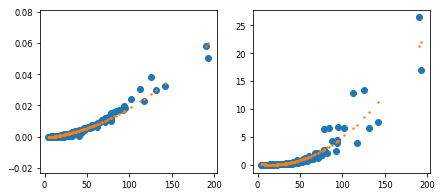

In [1029]:
plt.figure(figsize=(7, 3))
plt.subplot(1, 2, 1)
plt.scatter(unique_count, var_mean_diff)
plt.scatter(unique_count, mean_poly(unique_count), s=2)

# plt.xlim(0, 100);
# plt.ylim(-.01, 0.025)


plt.subplot(1, 2, 2)
plt.scatter(unique_count, var_var_diff)
plt.scatter(unique_count, var_poly(unique_count), s=2)
# plt.xlim(0, 100)
# plt.ylim(-1, 10)

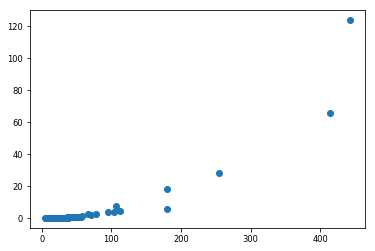

In [962]:
plt.scatter(unique_count, var_var_diff)

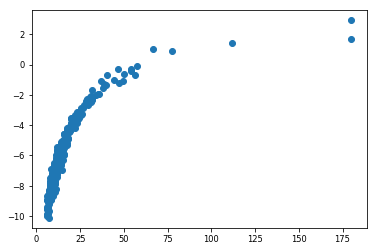

In [949]:
# x = unique_count[var_diff < 20]
# y = var_diff[var_diff < 20]
plt.scatter(x, np.log(y))
# plt.xlim(-1, 100);
# plt.ylim(-1, 5)

0.021007687605148317


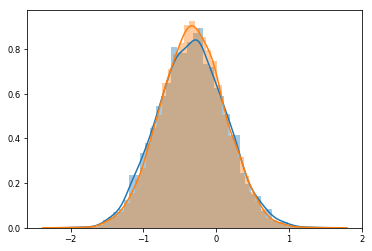

In [918]:
real_diff = var_2[:, 1]-var_1[:, 1]
approx_diff = var_2_approx-var_1_approx

print(real_diff.var() - approx_diff.var())
sns.distplot(real_diff)
sns.distplot(approx_diff)

0.06923541693269247


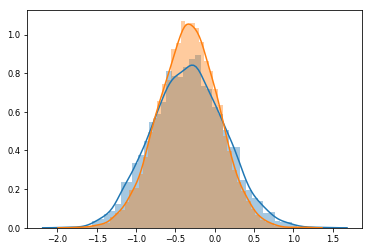

In [912]:
real_diff = var_2[:, 1]-var_1[:, 1]
approx_diff = var_2_approx-var_1_approx

print(real_diff.var() - approx_diff.var())
sns.distplot(real_diff)
sns.distplot(approx_diff)

In [880]:
estimator._poisson_1d(adata_1.X, adata_1.shape[0], size_factor=sf_1, n_umi=adata_scmemo.uns['scmemo']['n_umi'])[0][:5]

array([0.24232931, 5.48000079, 0.25818807, 0.46550617, 0.68077886])

In [881]:
mean_1_approx

array([5.48000079, 5.44506618, 5.42282228, ..., 5.50294022, 5.45590764,
       5.47020344])

In [882]:
print(mean_2[:,1].mean(), mean_2[:, 1].var())

5.558644360029925 0.0026377424548788614


In [883]:
print(mean_2_approx.mean(), mean_2_approx.var())

5.558722576631721 0.002516757062562083


In [884]:
mean_2[:, 2].var()

8.185131650504856e-05

In [885]:
mean_2[:, 2].mean()

0.26945125978318535

In [886]:
mean_2_approx.mean()

5.558722576631721

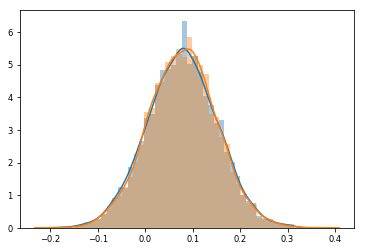

In [887]:
real_diff = mean_2[:, 1]-mean_1[:, 1]
approx_diff = mean_2_approx-mean_1_approx
sns.distplot(real_diff)
sns.distplot(approx_diff)

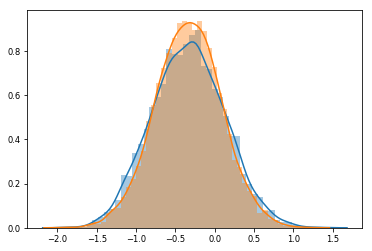

In [888]:
real_diff = var_2[:, 1]-var_1[:, 1]
approx_diff = var_2_approx-var_1_approx
sns.distplot(real_diff)
sns.distplot(approx_diff)

In [812]:
mean_diff.shape

(5000, 565)

In [813]:
mean_2_approx.shape

(5001,)

In [791]:
%%time
imp.reload(hypothesis_test)
imp.reload(scmemo)
imp.reload(estimator)
imp.reload(bootstrap)
a = scmemo.ht_1d_moments(
	adata_scmemo, 
	formula_like='1 + ct',
	cov_column='ct',
	inplace=False, 
	use_residual_var=False, 
	num_boot=5000, 
	bins=10,
	dirichlet_approx=True,
    log=True)

CPU times: user 42.2 s, sys: 5.88 ms, total: 42.2 s
Wall time: 42.2 s


In [792]:
-np.log(1/5000)

8.517193191416238

In [796]:
x = a.uns['scmemo']['1d_ht']['mean_asl']
x = x - np.nanmin(x)
x = x / np.nanmax(x)

(array([17., 15., 17.,  6., 10., 11.,  9., 11., 13., 11., 16., 10., 12.,
        11.,  7.,  4., 12., 14.,  6.,  9., 11., 13., 10., 14., 13., 14.,
        11., 10., 11., 11., 15., 13., 15.,  8.,  6., 10.,  6., 18., 14.,
        12., 11., 16.,  7.,  8., 10., 10., 11., 11., 11., 14.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

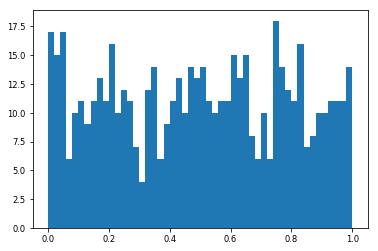

In [797]:
plt.hist(x, bins=50)

(array([33., 15., 25., 11., 11., 11., 11., 16.,  6., 13., 11., 13., 19.,
         9., 10., 17., 17.,  7., 14., 10., 12.,  7., 19., 10., 10., 10.,
         7.,  8., 10., 13.,  6.,  9., 13.,  7.,  9.,  6.,  8.,  7., 14.,
         8.,  4.,  9.,  9.,  4., 14., 10., 12., 13., 10.,  8.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

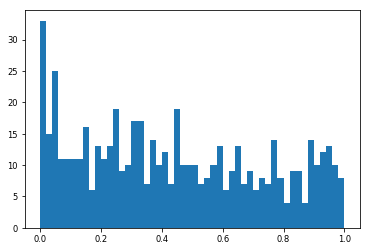

In [788]:
plt.hist(x, bins=50)

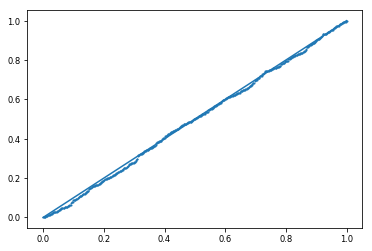

In [798]:
plt.scatter(
    np.linspace(0, 1, a.uns['scmemo']['1d_ht']['mean_asl'].shape[0]), 
    np.sort(x), s=1)
plt.plot([0, 1], [0, 1])

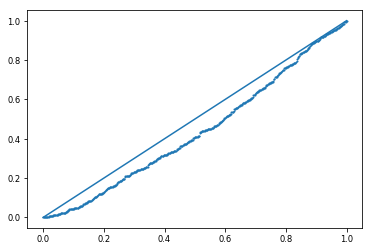

In [789]:
plt.scatter(
    np.linspace(0, 1, a.uns['scmemo']['1d_ht']['var_asl'].shape[0]), 
    np.sort(x), s=1)
plt.plot([0, 1], [0, 1])

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


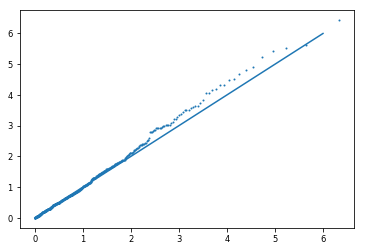

In [799]:
plt.scatter(
    -np.log(np.linspace(0, 1, a.uns['scmemo']['1d_ht']['mean_asl'].shape[0])), 
    -np.log(np.sort(x)), s=1)
plt.plot([0, 6], [0, 6])
# plt.xlim(0,5)
# plt.ylim(0,5)

(array([75., 70., 84., 68., 53., 71., 72., 65., 60., 57., 68., 64., 54.,
        64., 75.]),
 array([2.75565601e-05, 6.66520843e-02, 1.33276612e-01, 1.99901140e-01,
        2.66525667e-01, 3.33150195e-01, 3.99774723e-01, 4.66399251e-01,
        5.33023778e-01, 5.99648306e-01, 6.66272834e-01, 7.32897361e-01,
        7.99521889e-01, 8.66146417e-01, 9.32770945e-01, 9.99395472e-01]),
 <a list of 15 Patch objects>)

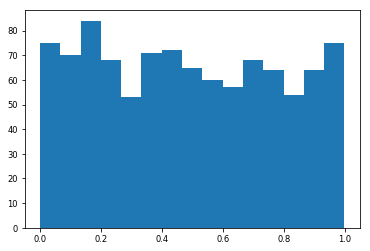

In [330]:
plt.hist(unif, bins=15)

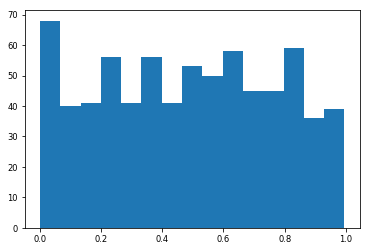

In [327]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=15);

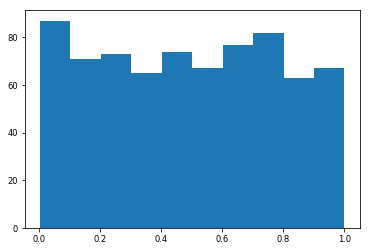

In [243]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=10);

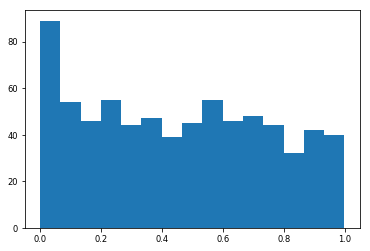

In [227]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=15);

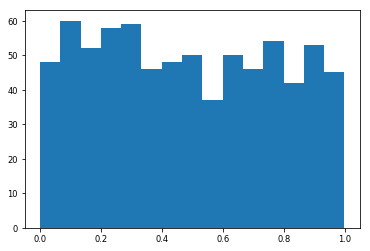

In [188]:
plt.hist(a.uns['scmemo']['1d_ht']['var_asl'], bins=15);

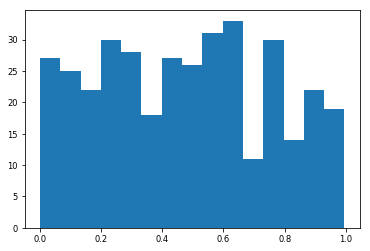

In [105]:
plt.hist(a.uns['scmemo']['1d_ht']['mean_asl'], bins=15);

## 

In [42]:
from sklearn.impute import SimpleImputer

In [44]:
a = np.array([1, 2, 3])

In [45]:
eval('a')

array([1, 2, 3])

In [534]:
imp.reload(hypothesis_test)
imp.reload(scmemo)
a = scmemo.ht_1d_moments(adata_scmemo, 'ct', inplace=False, use_residual_var=True)

In [535]:
a.uns['scmemo']['1d_ht']['design_matrix']

DesignMatrix with shape (2, 2)
  Intercept  ct[T.PBMC]
          1           1
          1           0
  Terms:
    'Intercept' (column 0)
    'ct' (column 1)

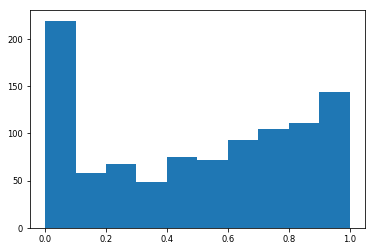

In [531]:
plt.hist(a.uns['scmemo']['1d_ht']['var_result'][2][1, :]);

In [491]:
%%time
# res_1 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=1)
# res_2 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=100000, verbose=True, bins=2)
res_3 = scmemo.bootstrap_1d_moments(adata_scmemo, inplace=False, num_boot=1000, verbose=True, bins=3)


sg^PBMC
CPU times: user 127 ms, sys: 60 ms, total: 186 ms
Wall time: 186 ms


In [463]:
from statsmodels.distributions.empirical_distribution import ECDF

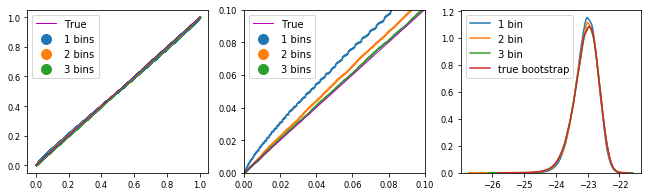

In [489]:
plt.figure(figsize=(11, 3))
plt.subplot(1, 3, 1)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 2)
plt.plot([-0,1], [-0,1], lw=1, color='m')
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_1[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_2[1]))),
    s=0.01)
plt.scatter(
    ecdf.y[1:],
    ecdf(np.sort(np.log(res_3[1]))),
    s=0.01)
plt.xlim(0, .1); plt.ylim(0, .1)
plt.legend(['True', '1 bins', '2 bins', '3 bins'], markerscale=100)

plt.subplot(1, 3, 3)
sns.distplot(np.log(res_1[1]), hist=False, label='1 bin')
sns.distplot(np.log(res_2[1]), hist=False, label='2 bin')
sns.distplot(np.log(res_3[1]), hist=False, label='3 bin')
sns.distplot(np.log(real_boot_vars), hist=False, label='true bootstrap')


### testout statsmodels

In [8]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [9]:
smf.wls

<bound method Model.from_formula of <class 'statsmodels.regression.linear_model.WLS'>>

In [495]:
nsample = 4
x = np.linspace(0, 20, nsample)
X = np.column_stack((x, (x - 5)**2))
X = sm.add_constant(X)
beta = [5., 0.5, -0.01]
sig = 0.5
w = np.ones(nsample)
w[nsample * 6//10:] = 10
y_true = np.dot(X, beta)
e = np.random.normal(size=nsample)
y = y_true + sig * w * e

In [496]:
def wlstq(X, y, weights):
    """ Perform weighted least squares and return the coefficients and the p-values. """

    inv = np.linalg.inv(X.T.dot(weights.reshape(-1,1)*X))
    beta = inv.dot(X.T*weights).dot(y)
    stde = np.sqrt(np.diag(inv))
        
    pval = 2*(1-stats.norm.cdf(np.abs(beta), 0, stde))
    
    return beta, stde, pval

In [6]:
a = np.array([1, 2, 3])

In [7]:
np.minimum(a, 10-a)

array([1, 2, 3])

In [497]:
%%time
wlstq(X, y, 1/w**2)

CPU times: user 1.26 ms, sys: 39 µs, total: 1.3 ms
Wall time: 472 µs


(array([ 5.18047275e+00,  4.30319706e-01, -1.95500966e-03]),
 array([1.2376279 , 0.20249106, 0.03845486]),
 array([2.84153475e-05, 3.35758176e-02, 9.59453751e-01]))

In [498]:
sm.WLS(y, X, weights=1./(w ** 2)).fit().summary()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.962
Model:                            WLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     12.71
Date:                Wed, 06 May 2020   Prob (F-statistic):              0.195
Time:                        22:35:34   Log-Likelihood:                -4.2024
No. Observations:                   4   AIC:                             14.40
Df Residuals:                       1   BIC:                             12.56
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.1805      0.542      9.566      0.066      -1.701      12.062
x1             0.4303      0.089      4.857      0.129      -0.696       1.556
x2            -0.0020      0.017     -0.116      0.926      -0.216       0.212
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.678
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.680
Skew:                           0.923   Prob(JB):                        0.712
Kurtosis:                       2.180   Cond. No.                         43.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
a = b = []

In [173]:
a

[]

In [175]:
a.append(1)

In [176]:
b

[1]

In [171]:
a, b, = []

ValueError: not enough values to unpack (expected 2, got 0)

In [159]:
from patsy import dmatrix, demo_data, ContrastMatrix, Poly, ModelDesc

In [160]:
ModelDesc.from_formula("y ~ x + x + x")

ModelDesc(lhs_termlist=[Term([EvalFactor('y')])],
          rhs_termlist=[Term([]), Term([EvalFactor('x')])])

In [147]:
data = demo_data("a", nlevels=3)

In [150]:
data = demo_data("a", "b", "x1", "x2")

In [151]:
data

{'a': ['a1', 'a1', 'a2', 'a2', 'a1', 'a1', 'a2', 'a2'],
 'b': ['b1', 'b2', 'b1', 'b2', 'b1', 'b2', 'b1', 'b2'],
 'x1': array([ 1.76405235,  0.40015721,  0.97873798,  2.2408932 ,  1.86755799,
        -0.97727788,  0.95008842, -0.15135721]),
 'x2': array([-0.10321885,  0.4105985 ,  0.14404357,  1.45427351,  0.76103773,
         0.12167502,  0.44386323,  0.33367433])}

In [544]:
a = dmatrix("x2 + b + x1 + a", pd.DataFrame(data))
a

DesignMatrix with shape (8, 5)
  Intercept  b[T.b2]  a[T.a2]        x2        x1
          1        0        0  -0.10322   1.76405
          1        1        0   0.41060   0.40016
          1        0        1   0.14404   0.97874
          1        1        1   1.45427   2.24089
          1        0        0   0.76104   1.86756
          1        1        0   0.12168  -0.97728
          1        0        1   0.44386   0.95009
          1        1        1   0.33367  -0.15136
  Terms:
    'Intercept' (column 0)
    'b' (column 1)
    'a' (column 2)
    'x2' (column 3)
    'x1' (column 4)

In [545]:
a.design_info.column_names

['Intercept', 'b[T.b2]', 'a[T.a2]', 'x2', 'x1']

In [354]:
dir(a.__dict__['design_info'])

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_repr_pretty_',
 'builder',
 'column_name_indexes',
 'column_names',
 'describe',
 'design_info',
 'factor_infos',
 'from_array',
 'linear_constraint',
 'slice',
 'subset',
 'term_codings',
 'term_name_slices',
 'term_names',
 'term_slices',
 'terms']

In [348]:
dir(a)

['T',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_finalize__',
 '__array_function__',
 '__array_interface__',
 '__array_prepare__',
 '__array_priority__',
 '__array_struct__',
 '__array_ufunc__',
 '__array_wrap__',
 '__bool__',
 '__class__',
 '__complex__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__divmod__',
 '__doc__',
 '__eq__',
 '__float__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__ilshift__',
 '__imatmul__',
 '__imod__',
 '__imul__',
 '__index__',
 '__init__',
 '__init_subclass__',
 '__int__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__irshift__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lshift__',
 '__lt__',
 '__matmul__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__or__',
 '__pos__',
 '__pow__',
 '__radd__',
 '__r

In [164]:
len(a)

8

In [101]:
%%time
df = pd.DataFrame(data=X, columns=['a', 'b'])
df['c'] = y
smf.wls('c ~ a + b', weights=1/w**2, data=df).fit().summary()

CPU times: user 12.7 ms, sys: 6 µs, total: 12.7 ms
Wall time: 11.6 ms


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      c   R-squared:                       0.861
Model:                            WLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     297.0
Date:                Wed, 06 May 2020   Prob (F-statistic):           3.40e-22
Time:                        18:13:19   Log-Likelihood:                -64.858
No. Observations:                  50   AIC:                             133.7
Df Residuals:                      48   BIC:                             137.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.7091      0.094     28.874      0.000       2.520       2.898
a              2.7091      0.094     28.874      0.000       2.520       2.898
b              0.4089      0.024     17.234      0.000       0.361       0.457
==============================================================================
Omnibus:                        0.049   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.976   Jarque-Bera (JB):                0.030
Skew:                           0.010   Prob(JB):                        0.985
Kurtosis:                       2.882   Cond. No.                     3.66e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.54e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [67]:
a['coef']

TypeError: 'Summary' object is not subscriptable

In [39]:
sm.WLS(y, X, weights=1./(w ** 2)).fit().summary()

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  "samples were given." % int(n), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.984
Model:                            WLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     61.43
Date:                Wed, 06 May 2020   Prob (F-statistic):             0.0808
Time:                        17:58:38   Log-Likelihood:                -1.0603
No. Observations:                   3   AIC:                             6.121
Df Residuals:                       1   BIC:                             4.318
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.6900      0.604     11.068      0.057      -0.991      14.370
x1             0.3004      0.038      7.838      0.081      -0.187       0.787
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.457
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.421
Skew:                          -0.528   Prob(JB):                        0.810
Kurtosis:                       1.500   Cond. No.                         49.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
X

array([[ 1.,  0.],
       [ 1.,  5.],
       [ 1., 10.],
       [ 1., 15.],
       [ 1., 20.]])